### Elsa RUELLE - Saphya EL OUAHABI

# Cleaning the third dataset

Source: https://www.kaggle.com/mirichoi0218/insurance?select=insurance.csv 


➡️ Can we accurately predict insurance costs?

Columns:

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance


➡️  "charges" is our target variable

In [1]:
import pandas as pd
#load the dataset
df = pd.read_csv('Raw_datasets/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [2]:
#dimensions 
df.shape

(1338, 7)

➡️ Handling missing data is important as many machine learning algorithms do not support data with missing values.

Here, we cannot realize (because of the number of lines in the dataframe) if there is missing information or incorherent values (for example 0 for the BMI or even the age).

➡️ How are we going to go about cleaning up the dataframe?

- we will identify/delete the missing/corrupted/outliers values
- we will process the categorical columns
- we will delete the columns we are not interested in
- we will normalize the data because it's necessary for BP

#### Identify the missing/corrupted/outliers values

In [3]:
# count the number of missing values for each column
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

➡️ There is no missing values.

In [4]:
# Are there people who are 0 years old, no charges or a bmi of 0?
df.loc[(df["age"]==0) | (df["bmi"]==0) | (df["charges"]==0),:]

,age,sex,bmi,children,smoker,region,charges


In [5]:
# sort values in an increasing way:
df['age'].sort_values() 

1248    18
482     18
492     18
525     18
529     18
        ..
398     64
335     64
378     64
1265    64
635     64
Name: age, Length: 1338, dtype: int64

➡️ Ages are between 18 and 64 years old so it doesn't seem problematic

In [6]:
df['bmi'].sort_values() 

172     15.960
428     16.815
1226    16.815
412     17.195
1286    17.290
         ...  
286     48.070
116     49.060
847     50.380
1047    52.580
1317    53.130
Name: bmi, Length: 1338, dtype: float64

➡️ We know that bmi is ideally between 18.5 to 24.9, here it's between 15.96. and 53.130. 
This interval does not seem wrong, there are probably overweight / obese and very thin / anorexic people in the dataset.

In [7]:
# summarize the dataset
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


➡️ Here, we can see that there is one column that have a minimum value of 0. In this case, the value of zero does make sense because it's normal to not have children.
The other columns seem correct too.

But let's see if there is any outlier thanks to some visualization tools:

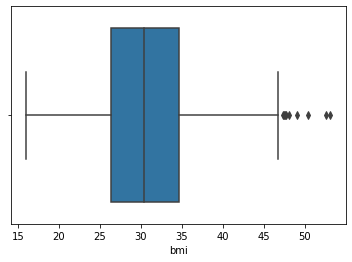

In [8]:
#box plot
import seaborn as sns
sns.boxplot(x=df['bmi'])

➡️ Above plot shows points between ~47 and ~53, these are outliers as there are not included in the box of other observation i.e no where near the quartiles.

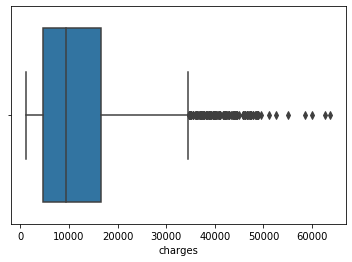

In [9]:
sns.boxplot(x=df['charges'])

➡️ same for the charges.

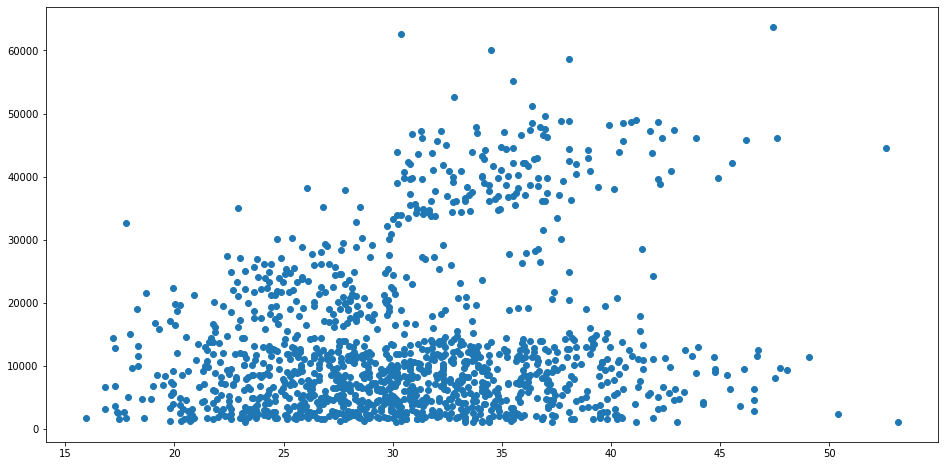

In [10]:
# Scatter plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['bmi'], df['charges'])
plt.show()

➡️ Looking at the plot above, we can most of data points are lying bottom left side and in the center but there are points which are far from the population like top right corner.

Let's use IQR method to detect and remove the outliers.
The IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.
It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.

IQR is somewhat similar to Z-score in terms of finding the distribution of data and then keeping some threshold to identify the outlier.

In [11]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
IQR

age            24.000000
bmi             8.397500
children        2.000000
charges     11899.625365
dtype: float64

In [12]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape


(1193, 7)

➡️ In the original dataframe there are 1338 rows so we can deduce that there are 145 outliers.

#### Process the categorical columns

"sex", "smoker" and "region" are the fields with qualitative values.

- For the "sex" variable, we will replace it with 2 columns: "IsFemale", "IsMale" with binary values to be able to perform the prediction.
- Unlike the variable "sex", the weight of the value of "smoker" is important. Being a smoker affects health so we will assign the value 1 to those who smoke and 0 who do not smoke, we will not create new columns.
- We don't really care about the 'region' column so we'll remove it in the next step.

In [13]:
#let's start with the sex variable:
df['sex'].value_counts()

female    611
male      582
Name: sex, dtype: int64

In [14]:
import numpy as np
df['IsFemale'] = np.where(df['sex']=="female", '1', '0')
df['IsMale'] = np.where(df['sex']=="male", '1', '0')

df.head()

C:\Users\selou\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\selou\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,age,sex,bmi,children,smoker,region,charges,IsFemale,IsMale
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1


In [15]:
#then with the smoker variable: 
df["smoker"].replace({"yes": 1, "no": 0}, inplace=True)

df.head()

C:\Users\selou\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,age,sex,bmi,children,smoker,region,charges,IsFemale,IsMale
0,19,female,27.900,0,1,southwest,16884.92400,1,0
1,18,male,33.770,1,0,southeast,1725.55230,0,1
2,28,male,33.000,3,0,southeast,4449.46200,0,1
3,33,male,22.705,0,0,northwest,21984.47061,0,1
4,32,male,28.880,0,0,northwest,3866.85520,0,1


#### Delete the columns we are not interested in

➡️ Let's delete the sex and region columns.

In [16]:
columns = ['sex','region']
df.drop(columns, inplace=True, axis=1)
df.head()

C:\Users\selou\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,age,bmi,children,smoker,charges,IsFemale,IsMale
0,19,27.900,0,1,16884.92400,1,0
1,18,33.770,1,0,1725.55230,0,1
2,28,33.000,3,0,4449.46200,0,1
3,33,22.705,0,0,21984.47061,0,1
4,32,28.880,0,0,3866.85520,0,1


#### Normalize data 

➡️ Normalization makes the features more consistent with each other, which allows the model to predict outputs more accurately.

We will use min-max normalization.
This is one of the most widely used methods of normalization. The result of the normalization subtracts the minimum value of a data frame and divides it by the difference between the highest and lowest value in the corresponding column.

In [17]:
def norm(df_input):
    return (df_input - df_input.min()) / ( df_input.max() - df_input.min())

In [18]:
columns = ['age','bmi','children','charges']
for col in columns:
    df[col]=norm(df[col])

C:\Users\selou\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
df.head()

,age,bmi,children,smoker,charges,IsFemale,IsMale
0,0.021739,0.387788,0.0,1,0.472641,1,0
1,0.000000,0.578435,0.2,0,0.018101,0,1
2,0.217391,0.553426,0.6,0,0.099775,0,1
3,0.326087,0.219065,0.0,0,0.625547,0,1
4,0.304348,0.419617,0.0,0,0.082306,0,1


In [20]:
df.shape

(1193, 7)

In [21]:
#export our final csv:
df.to_csv('Normalized_datasets/insurance_dataset_1.csv',index=False )